In [1]:
import torch
import random

import numpy as np
import matplotlib.pyplot as plt
import pretrained_microscopy_models as pmm

import vulture.comparisons.pmm_helpers as pmm_h

N CPUS: 110


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
device = "cuda"
arch: str = "UnetPlusPlus"
encoder: str = "resnet50"
pretrained_weights: str = "micronet"
sparse: bool = True

In [4]:
model = pmm_h.get_model(n_classes=3, arch=arch, encoder=encoder, pretrained_weights=pretrained_weights)

In [5]:
class_values = {'matrix': [85,85,85],
               'secondary': [170,170,170],
               'tertiary' : [255,255,255],
               }
class_values_original = {'matrix': [0,0,0],
               'secondary': [255,0,0],
               'tertiary' : [0,0,255]}
class_values_plus_unlabelled = {'matrix': [85,85,85],
               'secondary': [170,170,170],
               'tertiary' : [255,255,255],
               'unlabelled': [0, 0, 0]}

values = class_values_plus_unlabelled if sparse else class_values

In [6]:
DATA_PATH = "fig_data/CNN_comparison/ni_superalloy"
train_path = f"{DATA_PATH}/train_sparse_annot" if sparse else f"{DATA_PATH}/train_annot"
train_ds = pmm_h.get_dataset(values, f"{DATA_PATH}/train", train_path, "train")
val_ds = pmm_h.get_dataset(values, f"{DATA_PATH}/val", f"{DATA_PATH}/val_annot", "val")
test_ds = pmm_h.get_dataset(values, f"{DATA_PATH}/test", f"{DATA_PATH}/test_annot", "val")

In [7]:
masked_loss = pmm_h.MaskedDiceBCELoss(weight=0.7)
default_loss = pmm.losses.DiceBCELoss(weight=0.7)

loss = masked_loss if sparse else default_loss

In [8]:
n_epochs = 31
# for full run needs to be 150
save_per = 2
N_REPEATS = 5

results_dicts = []
for i in range(N_REPEATS):
    model = pmm_h.get_model(n_classes=3, arch=arch, encoder=encoder, pretrained_weights=pretrained_weights)
    results_dict, state = pmm_h.train_segmentation_model_with_eval(model, arch, encoder, train_ds, val_ds, values, 3, loss, n_epochs, save_per)
    results_dicts.append(results_dict)
    print(f'Training run for repeat {i} finished!')


Epoch: 0, lr: 0.00020000, time: 0.00 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s, DiceBCELoss - 0.7045]
[  0/31] (2.183): 0.1621

Epoch: 1, lr: 0.00020000, time: 4.14 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s, DiceBCELoss - 0.7053]

Epoch: 2, lr: 0.00020000, time: 2.09 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, DiceBCELoss - 0.7]   
[  2/31] (5.002): 0.1961

Epoch: 3, lr: 0.00020000, time: 3.28 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, DiceBCELoss - 0.6941]

Epoch: 4, lr: 0.00020000, time: 2.06 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, DiceBCELoss - 0.6884]
[  4/31] (7.814): 0.2767

Epoch: 5, lr: 0.00020000, time: 3.34 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s, DiceB

[[2.1830101013183594, 1.3976960182189941, 1.3864061832427979, 1.429213285446167, 1.3975484371185303], [5.001957654953003, 4.1869471073150635, 4.179361581802368, 4.259283781051636, 4.19897723197937], [7.814054250717163, 6.9702863693237305, 6.971416711807251, 7.114401817321777, 6.985939264297485], [10.597048997879028, 9.762708187103271, 9.775867223739624, 9.953490734100342, 9.764781951904297], [13.412253618240356, 12.553069829940796, 12.554784297943115, 12.803560018539429, 12.565051794052124]]
16


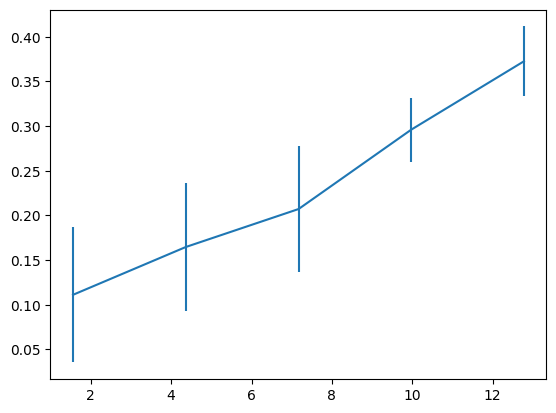

In [23]:
mious_per_epoch = [[d[i]['miou'] for d in results_dicts] for i in range(len(results_dict[0]))]
mean_miou = np.mean(mious_per_epoch, axis=-1)
std_miou = np.std(mious_per_epoch, axis=-1)

times_per_epoch = [[d[i]['tot_time'] for d in results_dicts] for i in range(len(results_dict[0]))]
print(times_per_epoch)
mean_time = np.mean(times_per_epoch, axis=-1)

plt.errorbar(mean_time, mean_miou, yerr=std_miou)

print(len(results_dicts[0]))

In [21]:
np.save('foo.npy', results_dicts )

In [9]:
# results_dict, state = pmm_h.iteratively_train_cnn(train_ds, val_ds, loss, values, 150, 10, 'iter')

In [10]:
%%capture
print(state['valid_loss'])

plt.plot(state['train_loss'], label='train_loss')
plt.plot(state['valid_loss'], label='valid_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [11]:
%%capture
plt.plot([i["tot_time"] for i in results_dict], [i["miou"] for i in results_dict])
plt.ylabel("mIoU")
plt.xlabel("Time (s)")

In [12]:
# out_dir = "fig_data/CNN_comparison/ni_superalloy/stored_CNN_results/"
# out_path = f"{out_dir}/sparse_data_4_imgs_e{n_epochs}.npy" if sparse else f"{out_dir}/full_data_4_imgs_e{n_epochs}.npy"
# np.save(out_path, results_dict)